# Post Deployment Pageview Check

[Task](https://phabricator.wikimedia.org/T261018)

Conduct a quick review of search-referred pageviews following the addition of alternate tags for mobile versions in [T255458](https://phabricator.wikimedia.org/T255458) on August 19, 2020 to confirm no negative impacts on traffic.

In [11]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
    library(lubridate); library(ggplot2); library(dplyr); library(RcppRoll)
})

In [6]:
# collect year over year pageviews by referrer class and search engine

query <-  "
SELECT
  CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')) AS date,
  IF(access_method = 'mobile web', 'mobile', 'desktop') AS site_version,
  IF(referer_class = 'external (search engine)', 'search', referer_class) AS referrer,
  SUM(view_count) AS pageviews
FROM wmf.projectview_hourly
WHERE year >= 2018 
  AND referer_class IN('none', 'internal', 'external', 'external (search engine)')
  AND agent_type = 'user'
GROUP BY
  CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')),
  IF(access_method = 'mobile web', 'mobile', 'desktop'),
  IF(referer_class = 'external (search engine)', 'search', referer_class)
"

In [7]:
daily_pageviews <-  wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [9]:
daily_pageviews$date <- as.Date(daily_pageviews $date, format = "%Y-%m-%d")

In [12]:
# Change was deployed on August 19th
daily_pageviews_clean <- daily_pageviews %>%  
mutate(period = if_else(date < "2020-08-19", "before", "after"))# change was deployed on October 2nd 2019

In [58]:
tail(daily_pageviews_clean)

,date,site_version,referrer,pageviews,period
,<date>,<chr>,<chr>,<int>,<chr>
7739,2020-08-12,mobile,search,161877160,before
7740,2020-08-13,desktop,internal,69401316,before
7741,2020-08-16,desktop,none,28899345,before
7742,2020-08-17,mobile,internal,99543824,before
7743,2020-08-22,mobile,external,2327608,after
7744,2020-08-23,desktop,search,66150200,after


In [61]:
search_yoy <- daily_pageviews_clean %>%
  filter(date >= '2018-07-01' & date <= '2018-08-23'|
        date>='2019-07-01' & date <= '2019-08-23'|
         date >= '2020-07-01'& date <= '2020-08-23', #focus on dates around deployment
    referrer == "search") %>%
  group_by(date, site_version, referrer) %>%
  summarize(pageviews = sum(pageviews)) %>%
  ungroup %>%
  mutate(
    year = factor(year(date)),
    site_version = if_else(site_version == "desktop", "Desktop version", "Mobile (web) version")
  ) %>%
  arrange(site_version, referrer, date) %>%
  group_by(site_version, referrer) %>%
  #mutate(smoothed = c(rep(NA, 3), RcppRoll::roll_mean(pageviews, 7), rep(NA, 3))) %>%
  ungroup
year(search_yoy$date) <- 2020

`summarise()` regrouping output by 'date', 'site_version' (override with `.groups` argument)



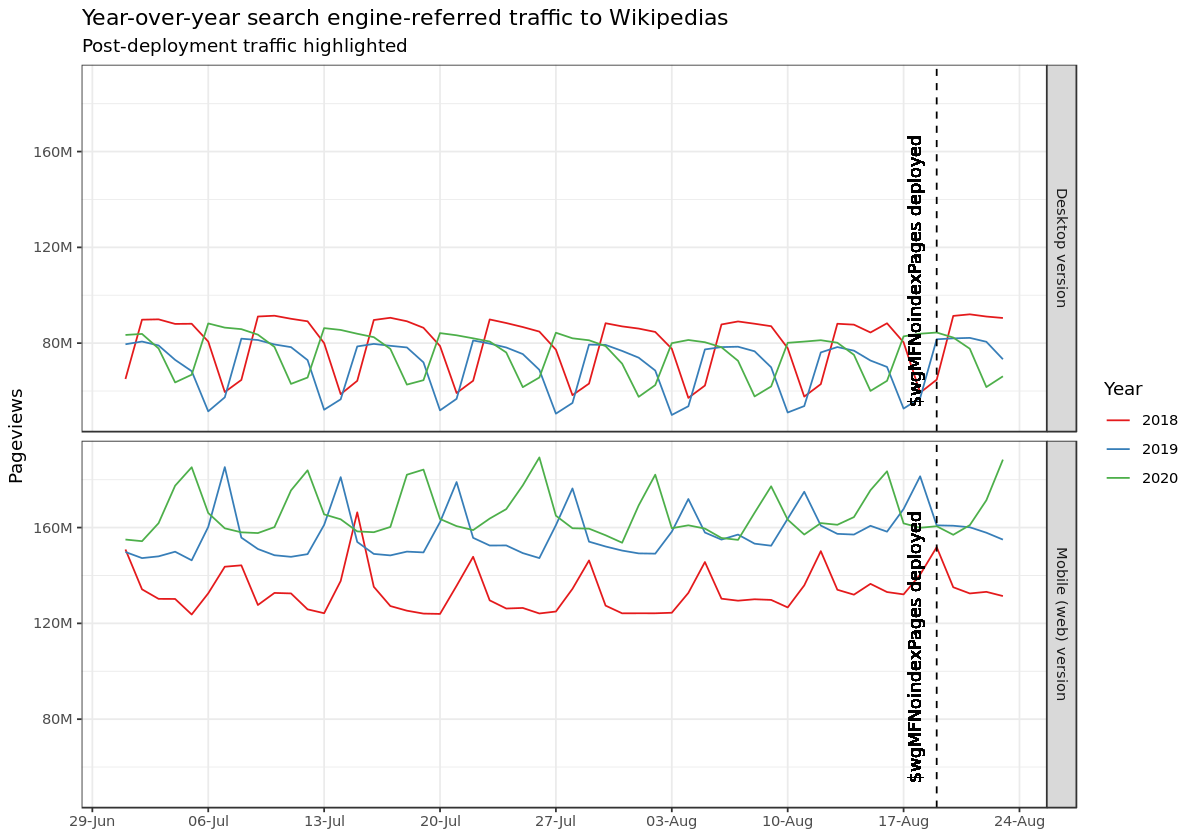

In [71]:
options(repr.plot.width = 10, repr.plot.height = 7)

p <- ggplot(search_yoy, aes(x = date, y = pageviews)) +
  geom_line(aes(color = year)) +
    geom_vline(xintercept = as.Date('2020-08-19'),
             linetype = "dashed", color = "black") +
      geom_text(aes(x=as.Date('2020-08-19'), y=110E6, label="$wgMFNoindexPages deployed"),  size=3.7, vjust = -1.2, angle = 90, color = "black") +
  facet_grid(site_version ~ .) +
  scale_x_date(date_labels = "%d-%b", date_breaks = "1 week", minor_breaks = NULL) +
  scale_y_continuous(labels = polloi::compress) +
  scale_color_brewer(palette = "Set1") +
  labs(
    x = NULL, y = "Pageviews", color = "Year",
    title = "Year-over-year search engine-referred traffic to Wikipedias",
    subtitle = "Post-deployment traffic highlighted"
 ) +
  theme(legend.position = "bottom") + 
  theme_bw()

p

ggsave("figures/post_deployment_pageviews_yoy.png", p, width = 18, height = 9, units = "in", dpi = 150)

